In [1]:
import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style='white', context='notebook', palette='deep')

train_df = pd.read_csv('./train.csv')

n_train = len(train_df)
n_pixels = len(train_df.columns) - 1
n_class = len(set(train_df['label']))

print('Number of training samples: {0}'.format(n_train))
print('Number of training pixels: {0}'.format(n_pixels))
print('Number of classes: {0}'.format(n_class))

train_df.head()

Using TensorFlow backend.


Number of training samples: 42000
Number of training pixels: 784
Number of classes: 10


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


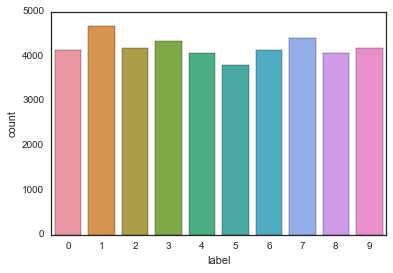

In [2]:
Y_train = train_df["label"]
X_train = train_df.drop("label", 1)
sns.countplot(Y_train)

### Visualizing Numbers by reshaping the image back to 28 x 28 

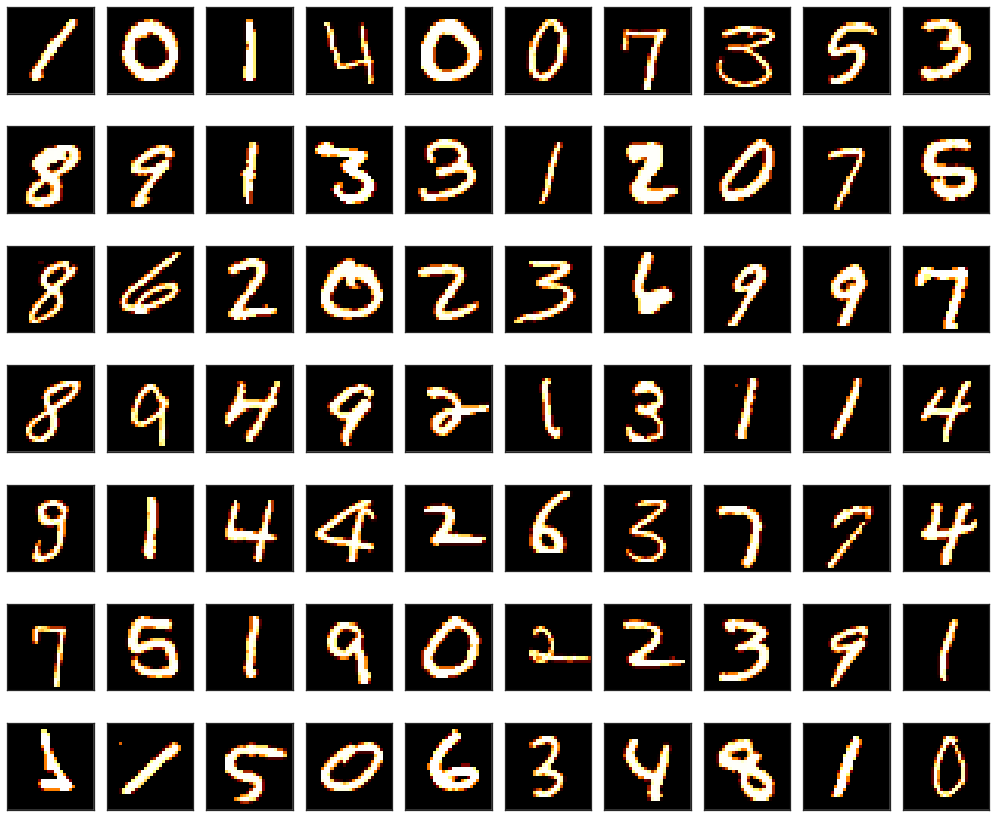

In [3]:
plt.figure(figsize=(14,12))
for digit_num in range(0,70):
    plt.subplot(7,10,digit_num+1)
    grid_data = X_train.iloc[digit_num].as_matrix().reshape(28,28)  # reshape from 1d to 2d pixel array
    plt.imshow(grid_data, interpolation = "none", cmap = "afmhot")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

### Machine Learning Stats on MNIST (without normalization)

In [18]:
# for i,text in enumerate(classifier):
#     result.loc[i+1] = [text,np.around(train_scores[i]*100, decimals = 1),np.around(test_scores[i]*100, decimals=1)]
# result.sort_values("Testing", ascending = False)

,Classifiers,Training,Testing
1,RandomForestClassifier,100.0,92.9
5,ExtraTreesClassifier,99.7,92.7
6,GradientBoostingClassifier,100.0,91.7
2,AdaBoostClassifier,76.8,75.3
4,DecisionTreeClassifier,74.5,68.1
3,SVM,100.0,11.1


### Machine Learning Stats on MNIST (with normalization/black-white)

In [24]:
# X_Train[X_Train>0]=1
# X_Test[X_Test>0]=1
# for i,text in enumerate(classifier1):
#     result1.loc[i+1] = [text,np.around(train_scores[i]*100, decimals = 1),np.around(test_scores1[i]*100, decimals=1)]
# result1.sort_values("Testing", ascending = False)

,Classifiers,Training,Testing
1,RandomForestClassifier,100.0,94.0
2,SVM,76.8,90.2


## Deep Learning - CNN using Keras (TF on GPU)

In [3]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1) 
X_train = X_train/255.0
X_train = X_train.values.reshape(-1,28,28,1)
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
Y_train = to_categorical(Y_train, num_classes = 10)

X_Train, X_Test, Y_Train, Y_Test = train_test_split(X_train,Y_train, test_size=.2)

## Visualization after reshape.. 


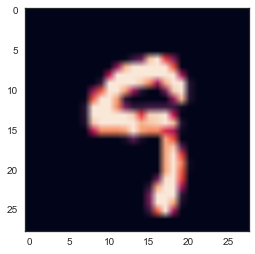

In [16]:
g = plt.imshow(X_Train[359][:,:,0])

## CNN Architecture :
### [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out


In [4]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

# Data Augmentation 

Trying to generate random data by zooming, shifting , tilting etc.. 

In [5]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_Train)

# Annealing : 
To converge the optimizer quickly, we reduce the learning rate by half if accuracy doest improve after 3 epochs.

In [8]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [10]:
epochs = 30
batch_size = 86
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
history = model.fit_generator(datagen.flow(X_Train,Y_Train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_Test,Y_Test),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/30
48s - loss: 0.4076 - acc: 0.8699 - val_loss: 0.0690 - val_acc: 0.9769
Epoch 2/30
45s - loss: 0.1346 - acc: 0.9589 - val_loss: 0.0559 - val_acc: 0.9824
Epoch 3/30
45s - loss: 0.0979 - acc: 0.9700 - val_loss: 0.0358 - val_acc: 0.9883
Epoch 4/30
44s - loss: 0.0885 - acc: 0.9745 - val_loss: 0.0330 - val_acc: 0.9889
Epoch 5/30
44s - loss: 0.0749 - acc: 0.9785 - val_loss: 0.0236 - val_acc: 0.9927
Epoch 6/30
44s - loss: 0.0741 - acc: 0.9789 - val_loss: 0.0254 - val_acc: 0.9923
Epoch 7/30
44s - loss: 0.0696 - acc: 0.9802 - val_loss: 0.0236 - val_acc: 0.9929
Epoch 8/30
44s - loss: 0.0705 - acc: 0.9804 - val_loss: 0.0248 - val_acc: 0.9919
Epoch 9/30
44s - loss: 0.0659 - acc: 0.9817 - val_loss: 0.0241 - val_acc: 0.9920
Epoch 10/30
44s - loss: 0.0678 - acc: 0.9805 - val_loss: 0.0229 - val_acc: 0.9932
Epoch 11/30
44s - loss: 0.0709 - acc: 0.9804 - val_loss: 0.0265 - val_acc: 0.9912
Epoch 12/30
44s - loss: 0.0682 - acc: 0.9819 - val_loss: 0.0292 - val_acc: 0.9912
Epoch 13/30
44s - loss: 0

### Use this if dont want to try any data augmentation and annealer

In [ ]:
# epochs = 30 # Turn epochs to 30 to get 0.9967 accuracy
# batch_size = 86
# optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
# history = model.fit(X_Train, Y_Train, batch_size = batch_size, epochs = epochs, validation_data = (X_Test, Y_Test), verbose = 2)

Train on 29400 samples, validate on 12600 samples
Epoch 1/30
33s - loss: 0.2971 - acc: 0.9058 - val_loss: 0.0718 - val_acc: 0.9779
Epoch 2/30


### Plotting validation and training losses...

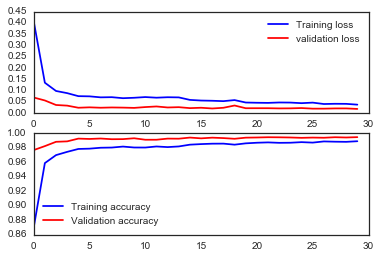

In [15]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [13]:
test_df = pd.read_csv('./test.csv')
test_df = test_df/255.0
test_df = test_df.values.reshape(-1,28,28,1)

## Got 99.5% on Kagle's test set

In [14]:
results = model.predict(test_df)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")

submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen_new.csv",index=False)